In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

In [3]:
plt.rcParams.update({'font.size': 15})

## The plotting handler

In [4]:
def plot_with_errorband(ax,trial_data,indices = None,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    if indices is None:
        indices = range(len(mu))
    
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [5]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

# Total LQR Cost vs $\bar{\eta}$

In [6]:
# etas = [0.1,0.5,1.0,1.5,2.0]
etas = [0.1]
control_alg = ['SafeLearning_eta_{}'.format(eta) for eta in etas] + ['ConstrainedDAP']

In [7]:
data = {}
  
costs = {alg:[] for alg in control_alg}

with open('./data/Parameters.pkl','rb') as f:
    data['Parameters'] = pkl.load(f)

Q = data['Parameters']['Q']
R = data['Parameters']['R']
A = data['Parameters']['A']
B = data['Parameters']['B']


for alg in control_alg:

    with open('./data/{}.pkl'.format(alg),'rb') as f:
        data[alg] = pkl.load(f)


    mean_cost = []
    std_cost = []

    x_hist = np.array([d['x'] for d in data[alg]])
    u_hist = np.array([d['u'] for d in data[alg]])
    
    print(alg,np.sum(cost(Q,x_hist)),np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis])))
    costs[alg] = cost(Q,x_hist)+cost(R,u_hist[:,:,np.newaxis,np.newaxis])      



SafeLearning_eta_0.1 310.2560806473201 10188.51625945768
ConstrainedDAP 206.983771679533 14600.23209352953


## LQR Stage Regret vs $t$

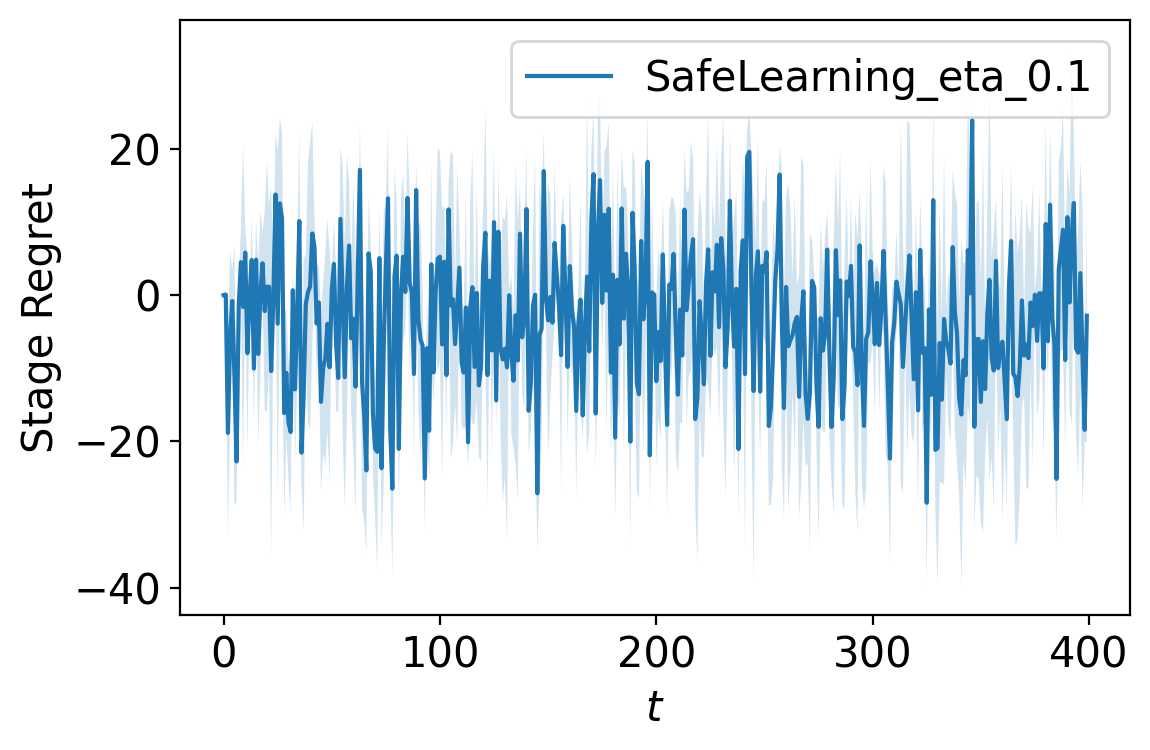

In [16]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        plot_with_errorband(ax,item-costs['ConstrainedDAP'],label=key)

ax.set_ylabel('Stage Regret')
ax.set_xlabel(r'$t$')
ax.legend()

plt.tight_layout()
plt.savefig('./figures/StageRegret.png')
plt.show()



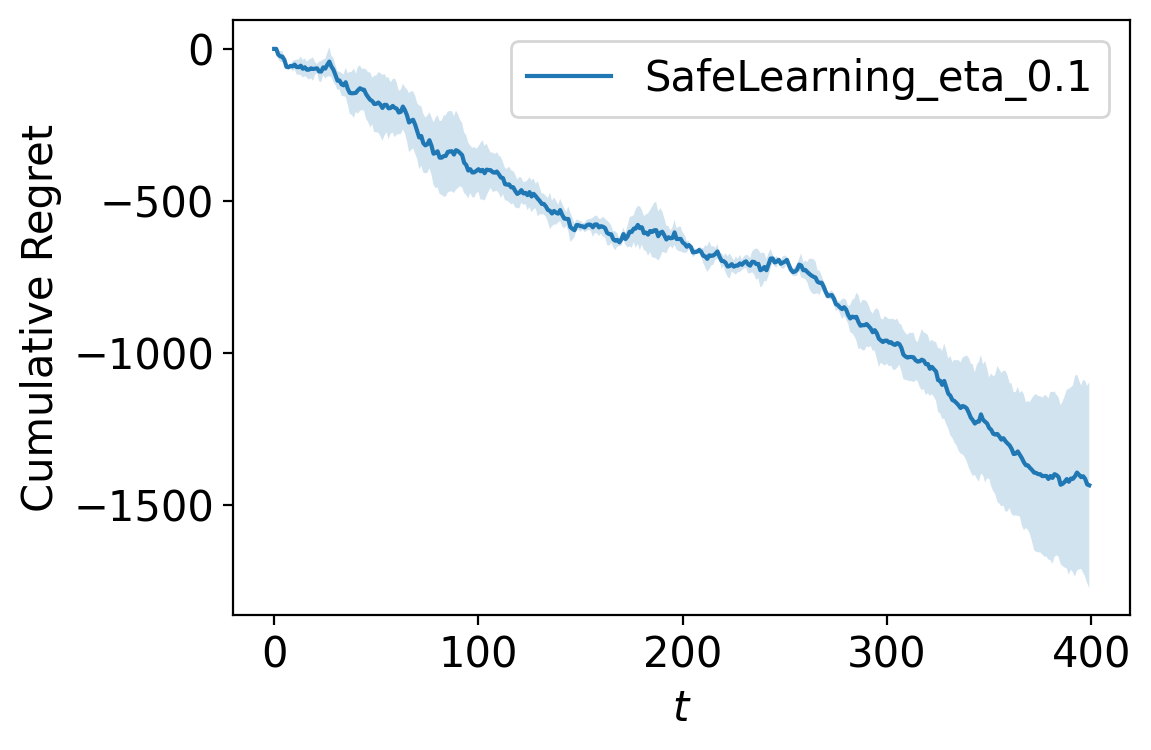

In [15]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        plot_with_errorband(ax,np.cumsum(item-costs['ConstrainedDAP'],axis=-1),label=key)

ax.set_ylabel('Cumulative Regret')
ax.set_xlabel(r'$t$')
ax.legend()

plt.tight_layout()
plt.savefig('./figures/CumulativeRegret.png')
plt.show()

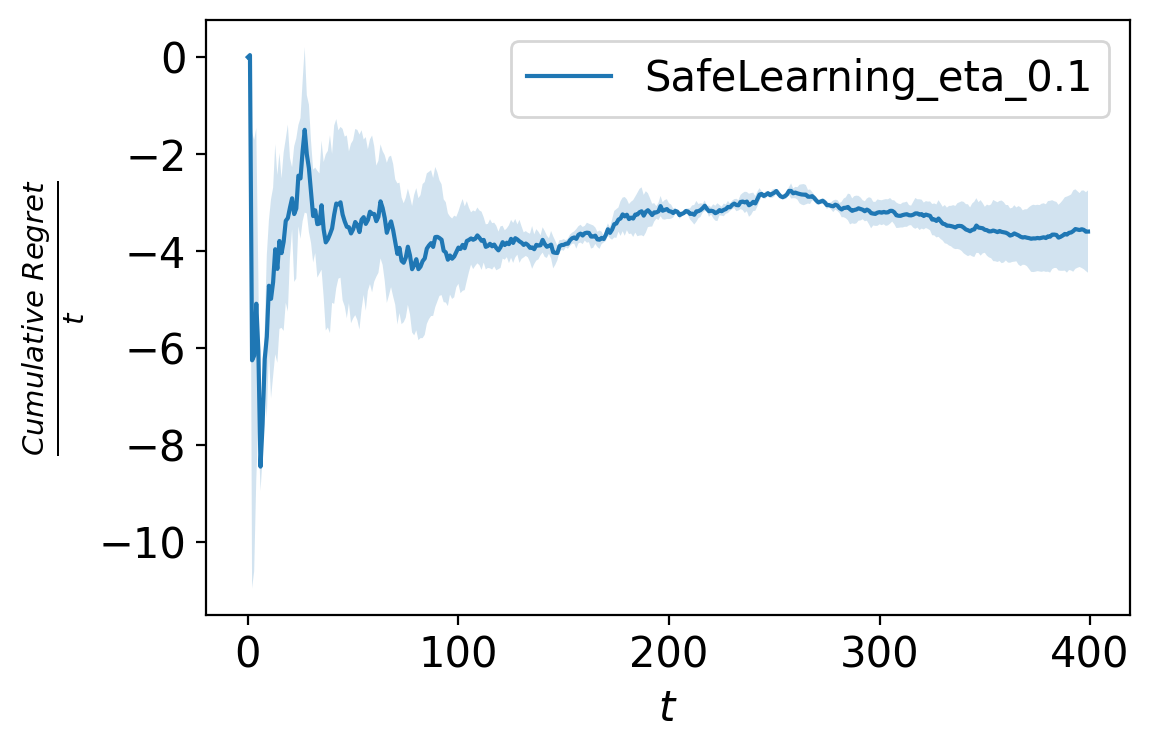

In [14]:
plt.figure(dpi=200)
ax = plt.gca()

for key,item in costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        times = np.arange(item.shape[1])+1
        plot_with_errorband(ax,np.cumsum(item-costs['ConstrainedDAP'],axis=-1)/times,label=key)


ax.set_ylabel(r'$\frac{Cumulative~Regret}{t}$')
ax.set_xlabel(r'$t$')
ax.legend()
plt.tight_layout()
plt.savefig('./figures/AveCumulativeRegret.png')
plt.show()

## Estimation error vs t.

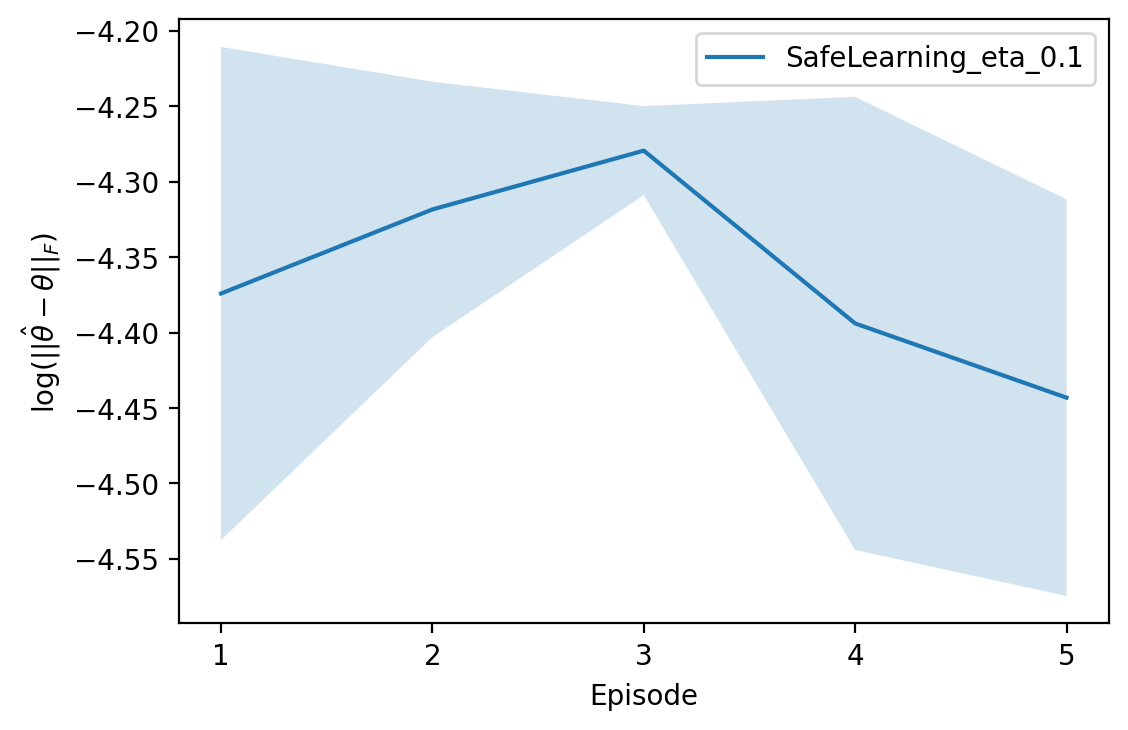

In [9]:
plt.figure(dpi=200)
ax = plt.gca()

for key,item in data.items():
    if key!='ConstrainedDAP' and key!='Parameters':
        thetas = [d['theta'] for d in item]

        As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
        Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        A_diff = np.linalg.norm(As-A,'fro',axis=(-1,-2))
        B_diff = np.linalg.norm(Bs-B,'fro',axis=(-1,-2))
        theta_diff = np.sqrt(A_diff**2+B_diff**2)
        
        
        
        plot_with_errorband(ax,np.log(theta_diff),1+np.arange(theta_diff.shape[1],),label=key)
        ax.set_xticks(range(1,theta_diff.shape[1]+1))
        ax.set_ylabel(r'$\log(||\hat{\theta}-\theta||_F)$')
        ax.set_xlabel(r'Episode')
ax.legend()
plt.show()


#         plt.figure(dpi=200)
#         ax = plt.gca()
#         plot_with_errorband(ax,A_diff,50*2*np.arange(A_diff.shape[1],))
#         ax.set_ylabel(r'$||\hat{A}-A||_F$')
#         ax.set_xlabel(r'$t$')
#         plt.show()

#         plt.figure(dpi=200)
#         ax = plt.gca()
#         plot_with_errorband(ax,B_diff,50*np.arange(A_diff.shape[1]))
#         ax.set_ylabel(r'$||\hat{B}-B||_F$')
#         ax.set_xlabel(r'$t$')
#         plt.show()